# Task 3: Image Classification for Grocery Items

**Goal:** 
- Take an image of a grocery item (e.g., an apple)
- Classify it as a specific product (e.g., "apple")
- Add it to a shopping list
- Use Task 1's model to categorize it (e.g., "Fruits & Vegetables")

**What approach?**
- We'll use a Convolutional Neural Network (CNN) to recognize images an detect patterns like edges, shapes, and textures
- We'll reuse Task 1's model to categorize the classified product

**Dataset:** 
- https://www.kaggle.com/datasets/liamboyd1/multi-class-food-image-dataset
- We have images organized in folders: train/val/test
- 8 product types: butter, cheese, eggs, milk, lettuce, onions, potatoes, spinach
- 2 categories: "Dairy & Eggs" and "Produce"

**Why This Technique?**
- Introducing convolutional neural networks (ML Zero to Hero - Part 3): https://www.youtube.com/watch?v=x_VrgWTKkiM
- Build an image classifier (ML Zero to Hero - Part 4): https://www.youtube.com/watch?v=u2TjZzNuly8



## Step 1: Import Libraries

**Why?** We need tools to:
- Load and preprocess images (keras.preprocessing)
- Build a CNN (keras, layers)
- Work with arrays (numpy)
- Display images (matplotlib)
- Load Task 1's model (pickle)


In [31]:
import os
import numpy as np
import keras
from keras import layers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Load Image Data

**Why?** We need to load images from folders and prepare them for training.

**What we're doing:**
- Our images are in a nested structure: `train/Category/Product/`
- We need product-level classification (butter, cheese, eggs, etc.), not category-level
- We'll create a custom function to load from nested folders
- Then use Keras's `image_dataset_from_directory` on a flattened structure

**Our folder structure:**
```
train/
  Dairy & Eggs/
    butter/    ← We want "butter" as a class
    cheese/    ← We want "cheese" as a class
    eggs/
    milk/
  Produce/
    lettuce/
    onions/
    potatoes/
    spinach/
```

**Why this approach?** We need 8 product classes, not 2 category classes!

**Train, val and test:** I've got three folders: train, val and test. Train is what the model actually learns from, the weights get updated on these images. Val (validation) is there so during training I can check how the model does on images it hasn't seen; that way I can spot overfitting (when training accuracy keeps going up but validation accuracy flattens or drops) and get a better sense of when to stop. I don't use val to update the model, just to measure. Test I use later after training I run the model on one image per product from the test folder to see how it does on completely new data. For this step we only need train and val; test comes in later.

**Why flattening?** Keras's `image_dataset_from_directory` expects one folder per class (e.g. butter/, cheese/, lettuce/). My data is nested as Category/Product (e.g. Dairy & Eggs/butter/), so if I pointed it at the raw folders it would think the two classes are "Dairy & Eggs" and "Produce" instead of the eight products. Flattening removes the category layer (e.g. Dairy, Produce) so the model can label images by product instead of by category.

![Step 2 results](../resultsimages/task3results/task3step2results.png)


In [32]:
# Set image size (all images will be resized to this)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Function to create temporary flattened structure for loading
def create_flattened_structure(source_dir, target_dir):

    import shutil
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir, exist_ok=True)
    
    product_folders = {}
    for root, dirs, files in os.walk(source_dir):
        # Check if we're at the product level (2 levels deep from source)
        rel_path = os.path.relpath(root, source_dir)
        parts = rel_path.split(os.sep)
        
        if len(parts) == 2:  # Category/Product level
            product_name = parts[1]  # Product name
            category_name = parts[0]  # Category name
            
            # Create product folder in target
            target_product_dir = os.path.join(target_dir, product_name)
            if not os.path.exists(target_product_dir):
                os.makedirs(target_product_dir)
                product_folders[product_name] = category_name
            
            # Copy image files
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_file = os.path.join(root, file)
                    dst_file = os.path.join(target_product_dir, file)
                    shutil.copy2(src_file, dst_file)
    
    return product_folders

# Create temporary flattened directories
print("Creating flattened structure for data loading...")
train_flat = 'train_flat_temp'
val_flat = 'val_flat_temp'

train_product_map = create_flattened_structure('train', train_flat)
val_product_map = create_flattened_structure('val', val_flat)

print(f"✓ Flattened structure created")
print(f"✓ Found {len(train_product_map)} product types")

# Load training data from flattened structure
train_dataset = keras.utils.image_dataset_from_directory(
    train_flat,
    labels='inferred',  # Use folder names (product names) as labels
    label_mode='categorical',  # One-hot encode labels
    color_mode='rgb',  # Color images
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,  # Randomize order
    seed=42
)

# Load validation data from flattened structure
val_dataset = keras.utils.image_dataset_from_directory(
    val_flat,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,  # Don't shuffle validation data
    seed=42
)

# Get class names (product types) use Keras's order (important for predictions!)
class_names = train_dataset.class_names
num_classes = len(class_names)

print(f"\n✓ Found {num_classes} product classes:")
for i, name in enumerate(class_names):
    category = train_product_map.get(name, "Unknown")
    print(f"  {i}: {name:15s} (from {category})")

print(f"\n✓ Training batches: {len(train_dataset)}")
print(f"✓ Validation batches: {len(val_dataset)}")


Creating flattened structure for data loading...
✓ Flattened structure created
✓ Found 8 product types
Found 11197 files belonging to 8 classes.
Found 2796 files belonging to 8 classes.

✓ Found 8 product classes:
  0: butter          (from Dairy & Eggs)
  1: cheese          (from Dairy & Eggs)
  2: eggs            (from Dairy & Eggs)
  3: lettuce         (from Produce)
  4: milk            (from Dairy & Eggs)
  5: onions          (from Produce)
  6: potatoes        (from Produce)
  7: spinach         (from Produce)

✓ Training batches: 350
✓ Validation batches: 88


## Step 3: Visualize Some Images

**Why?** Before I start training I like to check that the data actually looks right. If the labels were wrong or the images got corrupted, I'd rather spot it now than after training for ages. So I'm just displaying a few images from the training set with their labels so I can see that e.g. the "butter" folder really shows butter and the image size/resolution looks correct.

![Step 3 results](../resultsimages/task3results/task3step3results.png)


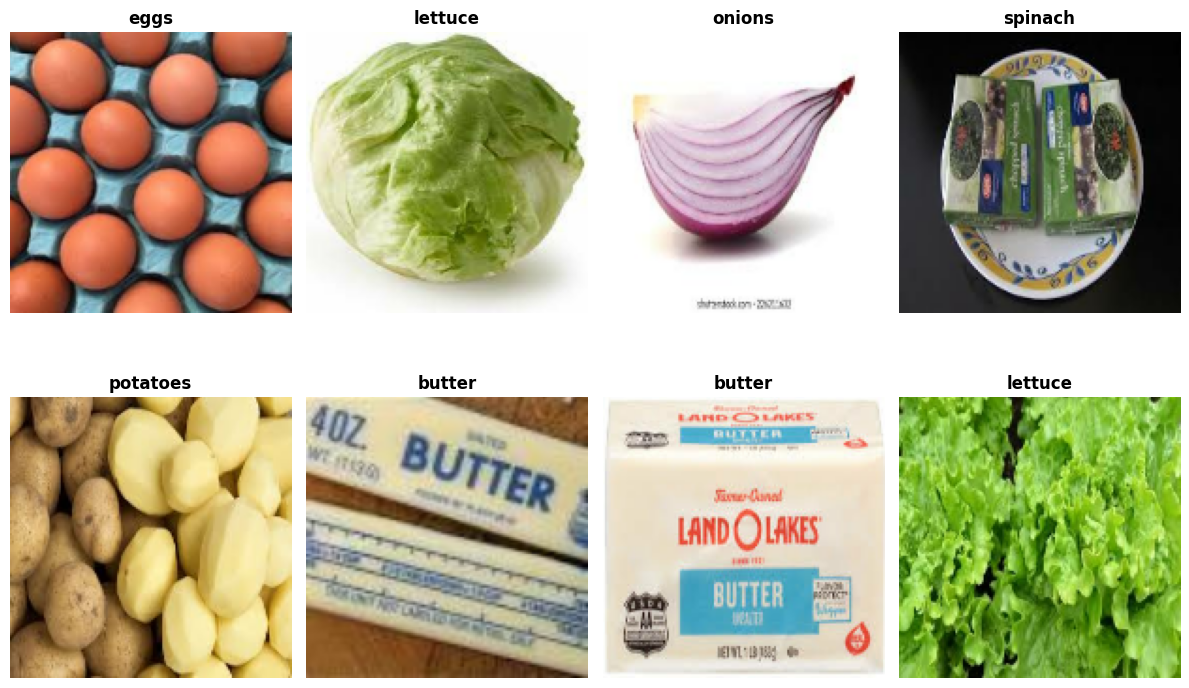

In [33]:
# Get a batch of images
for images, labels in train_dataset.take(1):
    # Display first 8 images
    plt.figure(figsize=(12, 8))
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i + 1)
        # Convert from tensor to numpy and display
        img = images[i].numpy().astype("uint8")
        label_idx = np.argmax(labels[i].numpy())
        plt.imshow(img)
        plt.title(f"{class_names[label_idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break  # Only show first batch


## Step 4: Build the CNN Model

**Why a CNN?** Convolutional layers are what make the model good at images. They slide small filters over the image and learn to detect edges, textures, and shapes. Pooling layers shrink the spatial size so we don't have too many parameters, and the dense layer at the end turns the learned features into a prediction for one of the 8 classes.

**Why this architecture?** I kept it fairly small so it wouldn't overfit too badly. I start with 32 filters to learn simple patterns like edges, then 64 and 128 to combine them into more complex patterns like "round shape" or "green leaves". I added RandomRotation and RandomFlip at the start so the model sees slightly different versions of each image during training that helps it generalise instead of memorising exact poses. Dropout(0.5) before the final layer randomly turns off half the neurons during training, which also helps prevent overfitting. The last layer has 8 units with softmax so the output is a probability for each product class.

**What each layer does:**
1. **RandomRotation / RandomFlip**: Data augmentation: small random transforms so the model sees varied examples
2. **Conv2D**: Detects patterns in small regions of the image
3. **MaxPooling2D**: Reduces size, keeps the strongest activations
4. **Flatten**: Converts the 2D feature maps into a 1D vector for the dense layer
5. **Dropout**: Regularisation so the model doesn't rely too much on any one feature
6. **Dense + Softmax**: Outputs probabilities for each of the 8 classes

## Rescaling (0-255 vs 0-1) and why it matters
https://github.com/Arsey/keras-transfer-learning-for-oxford102/issues/1

Rescaling means multiplying pixel values before any other processing. Raw images store RGB pixel values in the 0-255 range, which is relatively large for neural networks to handle efficiently at typical learning rates. A common practice is to normalize inputs to the 0-1 range by applying a 1/255 scaling factor, as recommended in Keras image classification workflows.

![Step 4 results](../resultsimages/task3results/task3step4results.png)


In [34]:
model = keras.Sequential([
    # Input: 150x150 RGB images
    keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    # Rescale pixels 0-255 -> 0-1
    layers.Rescaling(1./255),
    
    # Data augmentation (helps model generalize)
    layers.RandomRotation(0.1),  # Rotate slightly
    layers.RandomFlip("horizontal"),  # Flip horizontally
    
    # First convolutional block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten for dense layers
    layers.Flatten(),
    
    # Regularization
    layers.Dropout(0.5),  # Prevents overfitting
    
    # Final prediction layer
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │       295,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 389,192 (1.48 MB)

 Trainable params: 389,192 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Compile the Model

**Why?** Before training I have to tell the model how to measure how wrong it is (loss), how to update its weights to get better (optimizer), and what to report each epoch (metrics). Without this the model wouldn't know what to minimise or how to improve.

**Why these choices?** I'm doing multi-class classification with one label per image (butter, cheese, etc.), so **categorical_crossentropy** is the standard loss. It compares the model's probability distribution to the true one-hot label. **Adam** is a good default optimizer because it adapts the learning rate per parameter and usually converges without much tuning. I'm tracking **accuracy** so I can see what fraction of predictions are correct; it's easy to interpret and good enough for this task. Also, this was used in the example in class with the numbers.


In [35]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model compiled!")


✓ Model compiled!


## Step 6: Train the Model

**Why?** The model starts with random weights. It has to see the training images and update its weights so that its predictions get closer to the true labels. That's what training is: repeated passes over the data, each time reducing the loss a bit.

**What happens:** Each epoch the model goes through all the training batches. For each batch it predicts labels, computes the loss (categorical_crossentropy), and backpropagates to update the weights. I'm also passing the validation set so Keras can compute validation loss and accuracy after each epoch. That way I can see if the model is starting to overfit (training accuracy going up but validation going down).

**Why 10 epochs?** I wanted enough passes for the model to learn something (with 350 batches per epoch that's 3500 updates), but not so many that it memorises the training set. Ten seemed a reasonable starting point; if the validation accuracy was still climbing at epoch 10 I could increase it, and if validation started dropping earlier I'd know to use fewer epochs or add more regularisation.

***With Rescaling***
![Step 6 results](../resultsimages/task3results/task3step6results.png)

***Without Rescaling***
![Step 6 results (without rescaling)](../resultsimages/task3results/task3step6results1nonrescaled.png)

**Note:** We see that without rescaling, the model loss is huge at the beginning. Accuracy also ends lower.

In [36]:
EPOCHS = 10

print("Starting training...")
print("This may take a few minutes...\n")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1  # Show progress
)

print("\n✓ Training complete!")


Starting training...
This may take a few minutes...

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 67s 186ms/step - accuracy: 0.4379 - loss: 1.4673 - val_accuracy: 0.5089 - val_loss: 1.3176
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - accuracy: 0.5504 - loss: 1.2285 - val_accuracy: 0.5118 - val_loss: 1.3064
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 0.5855 - loss: 1.1226 - val_accuracy: 0.5719 - val_loss: 1.1612
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.6084 - loss: 1.0579 - val_accuracy: 0.5919 - val_loss: 1.1343
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.6266 - loss: 1.0125 - val_accuracy: 0.5855 - val_loss: 1.1082
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step - accuracy: 0.6475 - loss: 0.9564 - val_accuracy: 0.5951 - val_loss: 1.1070
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step - accuracy: 0.6614 - loss: 0.9376 - val_accuracy: 0.6159 - val_loss: 1.0462
Epoch 8/10
350/350 ━━━━━━━━━━━

## Step 7: Evaluate the Model

**Why?** I need to see how well the model actually works on data it wasn't trained on. Training accuracy can be misleading because the model might have memorised the training set; validation accuracy tells me how it does on images it's never seen before.

**What do the metrics mean?** **Validation accuracy** is the fraction of validation images the model classifies correctly. That's the main number I care about. **Validation loss** is the same loss function we used during training, but computed on the validation set; if it's going up while training loss is going down, that's a good sign of overfitting. I'm also plotting **training vs validation accuracy and loss** over the epochs so I can see whether the model was still improving at the end or if it had already started overfitting (validation curve flattening or dropping while training keeps improving).

***With Rescaling***
![Step 7 results](../resultsimages/task3results/task3step7results1rescaled.png)

***Without Rescaling***
![Step 7 results (non-rescaled)](../resultsimages/task3results/task3step7results1nonrescaled.png)

**Note:** We see that without rescaling, the model loss is huge at the beginning. We also see that non-rescaled model accuracy ends lower at 50% compared to rescaled 70%.


**My theory on why rescaling affects initial loss:**

**Without rescaling (pixels 0-255):**
Large pixel values -> large numbers flowing through the network.
At initialization, the model is struggling with numerical instability. The drop is a sign of the optimizer over-correcting for large input values, leading to an inefficient learning process.

**With rescaling (pixels 0-1):**
Small pixel values -> manageable numbers through the network
At initialization, the model starts at a higher baseline and improves steadily because the mathematical signals passing through the layers are within an ideal range for the activation functions.


Validation Accuracy: 62.12%
Validation Loss: 1.0473


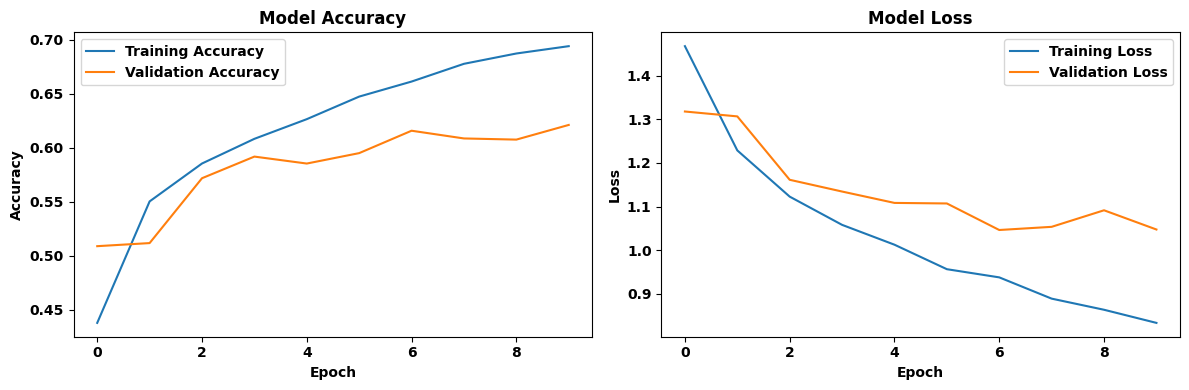

In [37]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()


## Step 8: Save the Model

**Why?** Training takes a while, and I don't want to have to run it again every time I want to classify an image. By saving the model and the class names I can load them later (e.g. in the shopping list part of the task) and run predictions without retraining.

**What we're saving:** The **.keras** file contains the full model architecture and trained weights, so Keras can load it exactly as it is. I'm also saving **class_names.pkl** (the list of product names in order) because the model outputs class indices (0-7); when I get a prediction I need to map that index back to "butter", "cheese", etc., and the class names list is what the data loader used, so the order matches.


In [38]:
# Save the model
model.save('grocery_image_classifier.keras')
print("✓ Model saved as 'grocery_image_classifier.keras'")

# Save class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("✓ Class names saved as 'class_names.pkl'")

print("\nThese files can be loaded later to classify new images!")


✓ Model saved as 'grocery_image_classifier.keras'
✓ Class names saved as 'class_names.pkl'

These files can be loaded later to classify new images!


## Step 9: Load Task 1's Model

**Why?** The CNN gives me a *product* (e.g. "lettuce", "milk"), but the task also wants a *category* (e.g. "Produce", "Dairy & Eggs") so the shopping list can group items. Task 1's decision tree was trained to predict category from item name, so I reuse it: once I have the product name from the CNN, I run it through the same feature extraction and Task 1's model to get the category.

**What we're doing:** I load the saved decision tree and label encoder from Task 1 (the .joblib files). I also need the **extract_features** function from Task 1 because the decision tree expects the same features (word length, first/last character, vowels, etc.) so I've copied that function here so I can turn a product name like "lettuce" into the feature vector that the Task 1 model was trained on. Then when I classify an image as "lettuce", I can pass "lettuce" to this pipeline and get "Produce" back. Hopefully.


In [39]:
# Copy the feature extraction function from Task 1 (task1dt1-saved.ipynb)
def extract_features(item_name):
    """Extract simple features from item name (from Task 1)"""
    item_lower = str(item_name).lower()
    features = []
    
    # Length of item name
    features.append(len(item_name))
    
    # First character (ASCII value)
    features.append(ord(item_lower[0]) if len(item_lower) > 0 else 0)
    
    # Last character (ASCII value)
    features.append(ord(item_lower[-1]) if len(item_lower) > 0 else 0)
    
    # Number of vowels
    vowels = 'aeiou'
    num_vowels = sum(1 for char in item_lower if char in vowels)
    features.append(num_vowels)
    
    # Number of consonants
    num_consonants = sum(1 for char in item_lower if char.isalpha() and char not in vowels)
    features.append(num_consonants)
    
    # Number of spaces
    features.append(item_name.count(' '))
    
    # Average character value
    if len(item_lower) > 0:
        features.append(sum(ord(c) for c in item_lower if c.isalpha()) / len([c for c in item_lower if c.isalpha()]) if any(c.isalpha() for c in item_lower) else 0)
    else:
        features.append(0)
    
    return features

# Load Task 1's model (from task1dt1-saved.ipynb: decision_tree_model.joblib, label_encoder.joblib)
import joblib
try:
    task1_model_path = Path('../task1/decision_tree_model.joblib')
    task1_encoder_path = Path('../task1/label_encoder.joblib')
    
    if task1_model_path.exists() and task1_encoder_path.exists():
        task1_model = joblib.load(task1_model_path)
        task1_label_encoder = joblib.load(task1_encoder_path)
        print("✓ Task 1's categorization model loaded successfully! (task1dt1-saved)")
        task1_available = True
    else:
        print("⚠ Task 1 model files not found. We'll skip categorization.")
        task1_available = False
except Exception as e:
    print(f"⚠ Could not load Task 1 model: {e}")
    task1_available = False


✓ Task 1's categorization model loaded successfully! (task1dt1-saved)


## Step 10: Create Shopping List and Classification Function

**Why?** This is where I tie everything together: I need a way to take an image path, run it through the CNN to get a product name, then use Task 1's model to get the category, and store the result in a shopping list so I can display it later.

**What we're doing:** I'm creating a shopping list (a list of dicts with image path, product, category, confidence) and three helper functions. **classify_image** loads the image, preprocesses it the same way as training (resize, normalise), runs the CNN, and returns the product name and confidence. **categorize_product** takes a product name and runs Task 1's feature extraction + decision tree to get the category. **add_to_shopping_list** combines these and appends the result to the list so I can call it whenever I classify a new image.


In [40]:
# Initialize shopping list
shopping_list = []

def classify_image(image_path, model, class_names):
    """
    Classify a single image
    
    Args:
        image_path: Path to image file
        model: Trained CNN model
        class_names: List of class names
    
    Returns:
        predicted_class: Name of predicted product
        confidence: Confidence score (0-1)
    """
    # Load and preprocess image
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    predicted_class = class_names[predicted_idx]
    
    return predicted_class, confidence

def categorize_with_task1(item_name, task1_model, task1_encoder):
    """
    Use Task 1's model to categorize an item
    
    Args:
        item_name: Name of the product
        task1_model: Task 1's trained model
        task1_encoder: Task 1's label encoder
    
    Returns:
        category: Predicted category name
    """
    try:
        features = np.array([extract_features(item_name)])
        prediction = task1_model.predict(features)  # sklearn: returns class index
        category_idx = prediction[0]
        category = task1_encoder.inverse_transform([category_idx])[0]
        return category
    except Exception as e:
        return f"Unknown (error: {e})"

def add_to_shopping_list(image_path, model, class_names, task1_model=None, task1_encoder=None):
    """
    Classify image, categorize it, and add to shopping list
    
    Returns:
        item_info: Dictionary with item details
    """
    # Classify the image
    product_name, confidence = classify_image(image_path, model, class_names)
    
    # Categorize using Task 1
    if task1_model is not None and task1_encoder is not None:
        category = categorize_with_task1(product_name, task1_model, task1_encoder)
    else:
        category = "Not categorized (Task 1 not available)"
    
    # Create item info
    item_info = {
        'product': product_name,
        'category': category,
        'confidence': confidence,
        'image_path': image_path
    }
    
    # Add to shopping list
    shopping_list.append(item_info)
    
    return item_info

print("✓ Functions created!")


✓ Functions created!


## Step 11: Test on Sample Images

**Why?** I want to check that the full pipeline works on real images from the test set. Images the model hasn't seen during training. So I pick a few test images, run each through classify_image and add_to_shopping_list, and display the predicted product and category next to the image. That way I can see if the CNN's predictions look sensible and if Task 1's categorisation is being applied correctly.

***With Rescaling***
![Step 11 results](../resultsimages/task3results/task3step11results.png)

***Without Rescaling***
![Step 11 results (without rescaling)](../resultsimages/task3results/task3step11results1nonrescaled.png)

**Note:** Both models incorrectly labelled cheese, but with Rescaling, model was able to recognize eggs with higher confidence.

In [41]:
# Test on one image from each category
test_images = []
products_tested = set()

# Walk through test folder and collect one image per product
for root, dirs, files in os.walk('test'):
    # Get the product name from the folder structure
    # root will be like 'test/Dairy & Eggs/butter'
    path_parts = root.split(os.sep)
    
    # Check if we're in a product folder (has image files)
    if len(path_parts) >= 3:  # test/category/product
        product = path_parts[-1]  # Get the product folder name
        
        # Skip if we already have an image from this product
        if product in products_tested:
            continue
        
        # Find the first image in this product folder
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(root, file))
                products_tested.add(product)
                print(f"Selected: {product}/{file}")
                break

print(f"\nTesting on {len(test_images)} images (one per product):\n")
print("=" * 70)

for img_path in test_images:
    # Classify and add to shopping list
    item_info = add_to_shopping_list(
        img_path, 
        model, 
        class_names,
        task1_model if task1_available else None,
        task1_label_encoder if task1_available else None
    )
    
    # Display results
    product_name = img_path.split(os.sep)[-2]  # Get actual product folder name
    print(f"\nImage: {os.path.basename(img_path)} (from {product_name}/)")
    print(f"  → Classified as: {item_info['product']} (confidence: {item_info['confidence']*100:.1f}%)")
    print(f"  → Category: {item_info['category']}")
    print(f"  → Added to shopping list!")

print("\n" + "=" * 70)
print(f"\n✓ Shopping list now has {len(shopping_list)} items!")

Selected: butter/butter.1.jpg
Selected: cheese/cheese.1.jpg
Selected: eggs/eggs.1.jpg
Selected: milk/milk.1.jpg
Selected: lettuce/lettuce.1.jpg
Selected: onions/onions.1.jpg
Selected: potatoes/potatoes.1.jpg
Selected: spinach/spinach.1.jpg

Testing on 8 images (one per product):


Image: butter.1.jpg (from butter/)
  → Classified as: butter (confidence: 100.0%)
  → Category: Dairy & Eggs
  → Added to shopping list!

Image: cheese.1.jpg (from cheese/)
  → Classified as: eggs (confidence: 48.1%)
  → Category: Bakery
  → Added to shopping list!

Image: eggs.1.jpg (from eggs/)
  → Classified as: eggs (confidence: 84.1%)
  → Category: Bakery
  → Added to shopping list!

Image: milk.1.jpg (from milk/)
  → Classified as: milk (confidence: 99.1%)
  → Category: Meat & Seafood
  → Added to shopping list!

Image: lettuce.1.jpg (from lettuce/)
  → Classified as: lettuce (confidence: 97.5%)
  → Category: Condiments & Sauces
  → Added to shopping list!

Image: onions.1.jpg (from onions/)
  → Classif

## Step 12: Display Shopping List

**Why?** After adding a few images in Step 11 I want to show the full shopping list in one place, each item with its image, predicted product name, category (from Task 1), and the CNN's confidence. That gives a clear summary of what the pipeline produced and makes it easy to spot any misclassifications or odd categories.

***Rescaled (example 1)***
![Step 12 results (rescaled 1)](../resultsimages/task3results/task3step12results1rescaled.png)

***Non-rescaled (example 1)***
![Step 12 results (non-rescaled 1)](../resultsimages/task3results/task3step12results1nonrescaled.png)

***Rescaled (example 2)***
![Step 12 results (rescaled 2)](../resultsimages/task3results/task3step12results2rescaled.png)

***Non-rescaled (example 2)***
![Step 12 results (non-rescaled 2)](../resultsimages/task3results/task3step12results2nonrescaled.png)

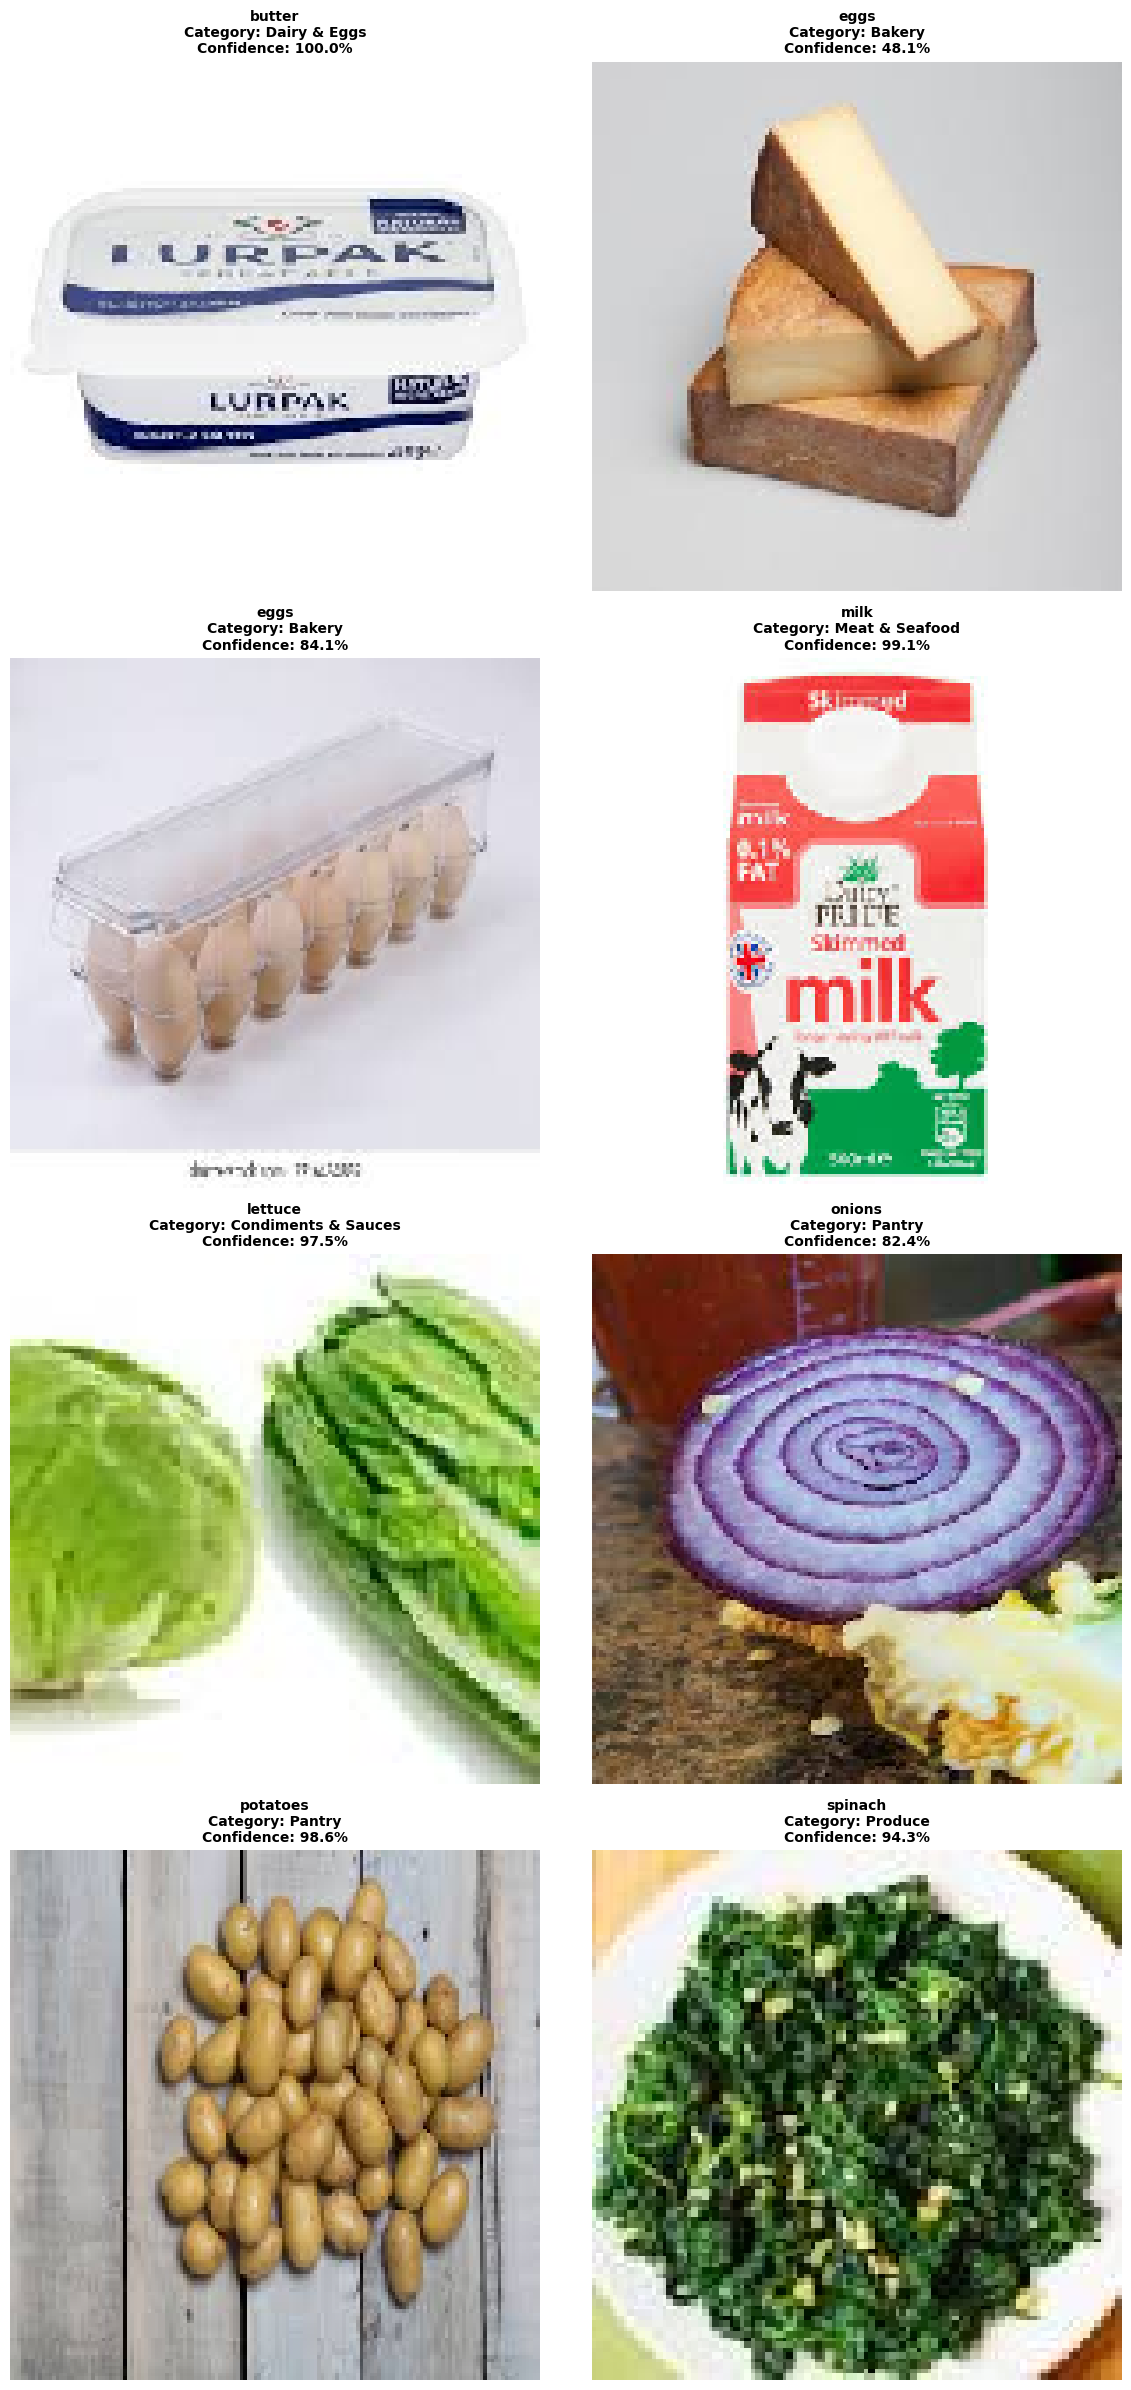


SHOPPING LIST SUMMARY
1. butter               → Dairy & Eggs              (100.0% confidence)
2. eggs                 → Bakery                    (48.1% confidence)
3. eggs                 → Bakery                    (84.1% confidence)
4. milk                 → Meat & Seafood            (99.1% confidence)
5. lettuce              → Condiments & Sauces       (97.5% confidence)
6. onions               → Pantry                    (82.4% confidence)
7. potatoes             → Pantry                    (98.6% confidence)
8. spinach              → Produce                   (94.3% confidence)


In [42]:
if len(shopping_list) > 0:
    num_items = len(shopping_list)
    cols = 2
    rows = (num_items + 1) // 2
    
    plt.figure(figsize=(12, 6 * rows))
    
    for i, item in enumerate(shopping_list):
        plt.subplot(rows, cols, i + 1)
        
        # Load and display image
        img = image.load_img(item['image_path'], target_size=IMG_SIZE)
        plt.imshow(img)
        
        # Create title with info
        title = f"{item['product']}\n"
        title += f"Category: {item['category']}\n"
        title += f"Confidence: {item['confidence']*100:.1f}%"
        
        plt.title(title, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 70)
    print("SHOPPING LIST SUMMARY")
    print("=" * 70)
    for i, item in enumerate(shopping_list, 1):
        print(f"{i}. {item['product']:20s} → {item['category']:25s} ({item['confidence']*100:.1f}% confidence)")
else:
    print("Shopping list is empty. Add some images first!")


## Step 13: Results Analysis


### Rescaling (0-255 vs 0-1) and why it matters
https://github.com/Arsey/keras-transfer-learning-for-oxford102/issues/1

Through this project, I learned that rescaling is not just a technical detail but something that directly affects how well the model learns.

We see how this affected the final test. The rescaled model was able to correctly classify onions as onions. When the rescaled layer is removed, model more often misclassified onions as spinach or milk. This showed me that normalization is not only about consistency between training and prediction, but also about helping the model learn more stable and discriminative features, especially when classes look visually similar.

### What Worked Well?

1. **CNN Architecture**: The convolutional layers successfully learned to detect patterns in images
   - Low-level features (edges, textures) from early layers
   - High-level features (shapes, objects) from deeper layers

2. **Data Organization**: Having images organized in folders made loading easy
   - Keras automatically labeled images based on folder names
   - Train/val/test split helped evaluate performance

3. **Integration with Task 1**: Successfully reused Task 1's model
   - Classified products (e.g., "apple") were categorized (e.g., "Produce")
   - Shows how different ML tasks can work together

### What Could Be Improved?

1. **Model Accuracy**: 
   - Current accuracy depends on training quality
   - Could improve with more data, better augmentation, or transfer learning

2. **Task 1 Limitations**: 
   - Task 1's model has ~15% accuracy, so categories might be wrong


3. **Limited Product Types**: 
   - Only 8 products in 2 categories
   - Real grocery stores have hundreds of thousands of products

### Why These Results?

1. **Good Results**: 
   - CNN is the right technique for images (detects visual patterns)
   - Sufficient training data for each class
   - Clear visual differences between products

2. **Challenges**:
   - Similar-looking items (e.g., different types of cheese) might be confused
   - Lighting, angle, background variations affect classification
   - Task 1's low accuracy limits categorization quality
